## Assignment #4 FRED Data Analysis

Objective:
Download and plot 3 apparently related sets of data with at least. Each set should contain at least two related variables. You should explain how variables in each set of data are related. Plot each set using the scatter plot function and the line graph function.

Create a correlation matrix plot for quarterly observations of Nominal GDP, Real GDP, the Price Level (CPI or GDP Deflator), the quantity of currency in circulation for as large of a date range as possible. Then, calculate the year-over-year percent change for each each variable and save the results as variables in the same dataframe. Create a correlation matrix for these new variables.

Download data for 1 Year, 2 Year, 5 Year, 10 Year, and 30 Year U.S. Treasuries (Constant Maturity Rates). Create a function that creates a yield for each date.

Plot all of the variables from (3) in a single time series line plot. Indicate using shaded regions any period where the 5 Year rate is less than the 1 year rate. Save this plot in the same pdf that you used in (3).

In [2]:
#plots.py
import os
import pandas
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import datetime
import math

def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            # setting i to None will cause the next block of code to execute,
            # placing data within df instead of creating a new dataframe for
            # each variable
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()

    return df

def plot_ts_scatter(df, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    plot_vars = list(df.keys())
    for var1 in plot_vars:
        for var2 in plot_vars:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(plot_vars).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_lines(df, title = False, linewidth = 1, figsize = (40,20), full_index = False, 
               h_line = False, max_y = False, legend = True, pp = None, show_inversion = False):
    fig, ax = plt.subplots(figsize = figsize)
    # If no secondary_y (axis), plot all variables at once
    df.plot.line(linewidth = linewidth, ax = ax, legend = legend)
    if h_line != False:
        ax.axhline(h_line, ls = "--", linewidth = 1.5, color = "k")
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    if max_y != False:
        ax.set_ylim(bottom = 0, top = max_y)
    if full_index:
        plt.xticks([i for i in range(len(df.index))], list(df.index))
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals]) 

    # transform y-axis values from sci notation to integers
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals]) 
    if title != False:
        plt.title(title, fontsize = 72)

    if show_inversion:
        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.fill_between(df.index, 0, df.max().max(), where=df["2 Y (%)"] < df["1 M (%)"],
                    facecolor='red', alpha=0.2, transform = trans)
    # format image filename 
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")
    plt.savefig(filename[:50] + " line.png",
                bbox_inches = "tight")
    #[:50] + " line.png"
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_stacked_lines(df, plot_vars, linewidth = 1, figsize = (40,20), 
                       pp = None, total_var = False):
    fig, ax = plt.subplots(figsize = figsize)
#    mpl_colors = ["C" + str(i) for i in range(11)]
    df[plot_vars].plot.area(stacked = True, linewidth = linewidth,
                            ax = ax)
    if total_var != False:
        df[total_var].plot.line(linewidth = linewidth, ax = ax, c = "k",
              label = total_var, ls = "--")
    ax.legend(loc=2, ncol = 2)

In [3]:
data_codes  = {"IOER (%)":"IOER",
              "EFFR (%)": "DFF",
              "1 M (%)": "DGS1MO",
              "3 M (%)": "DGS3MO",
              "6 M (%)": "DGS6MO",               
              "1 Y (%)": "DGS1",
              "2 Y (%)": "DGS2",
              "3 Y (%)": "DGS3",
              "5 Y (%)": "DGS5",
              "7 Y (%)": "DGS7",
              "10 Y (%)": "DGS10",
              "20 Y (%)": "DGS20",
              "30 Y (%)": "DGS30",
              "Expected Inflation (%)":"T10YIE",
              "Inflation (%)": "CPIAUCSL"}
               
# Select start and end dates
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
data = gather_data(data_codes = data_codes, start = start, end = end, freq = "M").dropna()
#data["30 Y - 1 M"] = data["30 Y (%)"].add(-1 * data["1 M (%)"])
data["Inflation (%)"] = data["Inflation (%)"].pct_change(12)*100

In [4]:
data.dropna()

,IOER (%),EFFR (%),1 M (%),3 M (%),6 M (%),1 Y (%),2 Y (%),3 Y (%),5 Y (%),7 Y (%),10 Y (%),20 Y (%),30 Y (%),Expected Inflation (%),Inflation (%)
DATE,,,,,,,,,,,,,,,
2009-10-31,0.250000,0.118065,0.040952,0.074286,0.160476,0.374762,0.949048,1.463810,2.332857,2.963333,3.387619,4.162381,4.188571,1.904286,-0.223968
2009-11-30,0.250000,0.119000,0.052632,0.052105,0.154737,0.313158,0.803158,1.316316,2.230526,2.921579,3.402632,4.235263,4.314737,2.127368,1.914587
2009-12-31,0.250000,0.118065,0.031818,0.054545,0.167727,0.371364,0.874545,1.383182,2.340455,3.074545,3.590000,4.399545,4.494091,2.225455,2.814123
2010-01-31,0.250000,0.110000,0.022632,0.061579,0.148421,0.345789,0.928947,1.492105,2.484211,3.208947,3.733158,4.501579,4.604737,2.358421,2.621111
2010-02-28,0.250000,0.126429,0.057368,0.108947,0.181053,0.345789,0.856842,1.401053,2.363684,3.122632,3.691053,4.481053,4.619474,2.272105,2.151336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31,0.100000,0.069677,0.024348,0.031304,0.052609,0.075652,0.146957,0.316522,0.823043,1.270435,1.610870,2.237391,2.339130,2.275217,2.637322
2021-04-30,0.100000,0.069000,0.016364,0.020909,0.039091,0.060909,0.163182,0.345909,0.861818,1.307273,1.635000,2.197727,2.299545,2.349545,4.153135
2021-05-31,0.100000,0.058065,0.007500,0.018000,0.035500,0.050500,0.155000,0.324000,0.819500,1.279000,1.621000,2.215000,2.316000,2.468000,4.926507


In [17]:
data.keys()

Index(['Unemployment Rate (%)', 'Initial Claims (N)',
       'All Employees, Total Nonfarm (N)'],
      dtype='object')

<AxesSubplot:xlabel='DATE'>

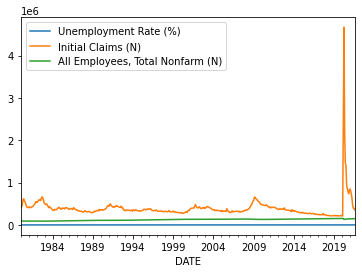

In [6]:
# Creating line graphs
# Pulling the data from library
from datlib.plots import * 
from datlib.FRED import *
# data I am pulling from library
data_codes  = {"Unemployment Rate (%)": "UNRATE", 
               "Initial Claims (N)": "ICSA",
              "All Employees, Total Nonfarm (N)": "PAYEMS"}
# Select start and end dates
start = datetime.datetime(1980, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
data = gather_data(data_codes = data_codes, start = start, end = end, freq = "M")

start = datetime.datetime(1980, 1, 1)
end = datetime.datetime.today()
data = gather_data(data_codes = data_codes, 
                   start = start,
                  end = end,
                  freq = "M")
plt.rcParams.update({"font.size":10})
data.plot.line()

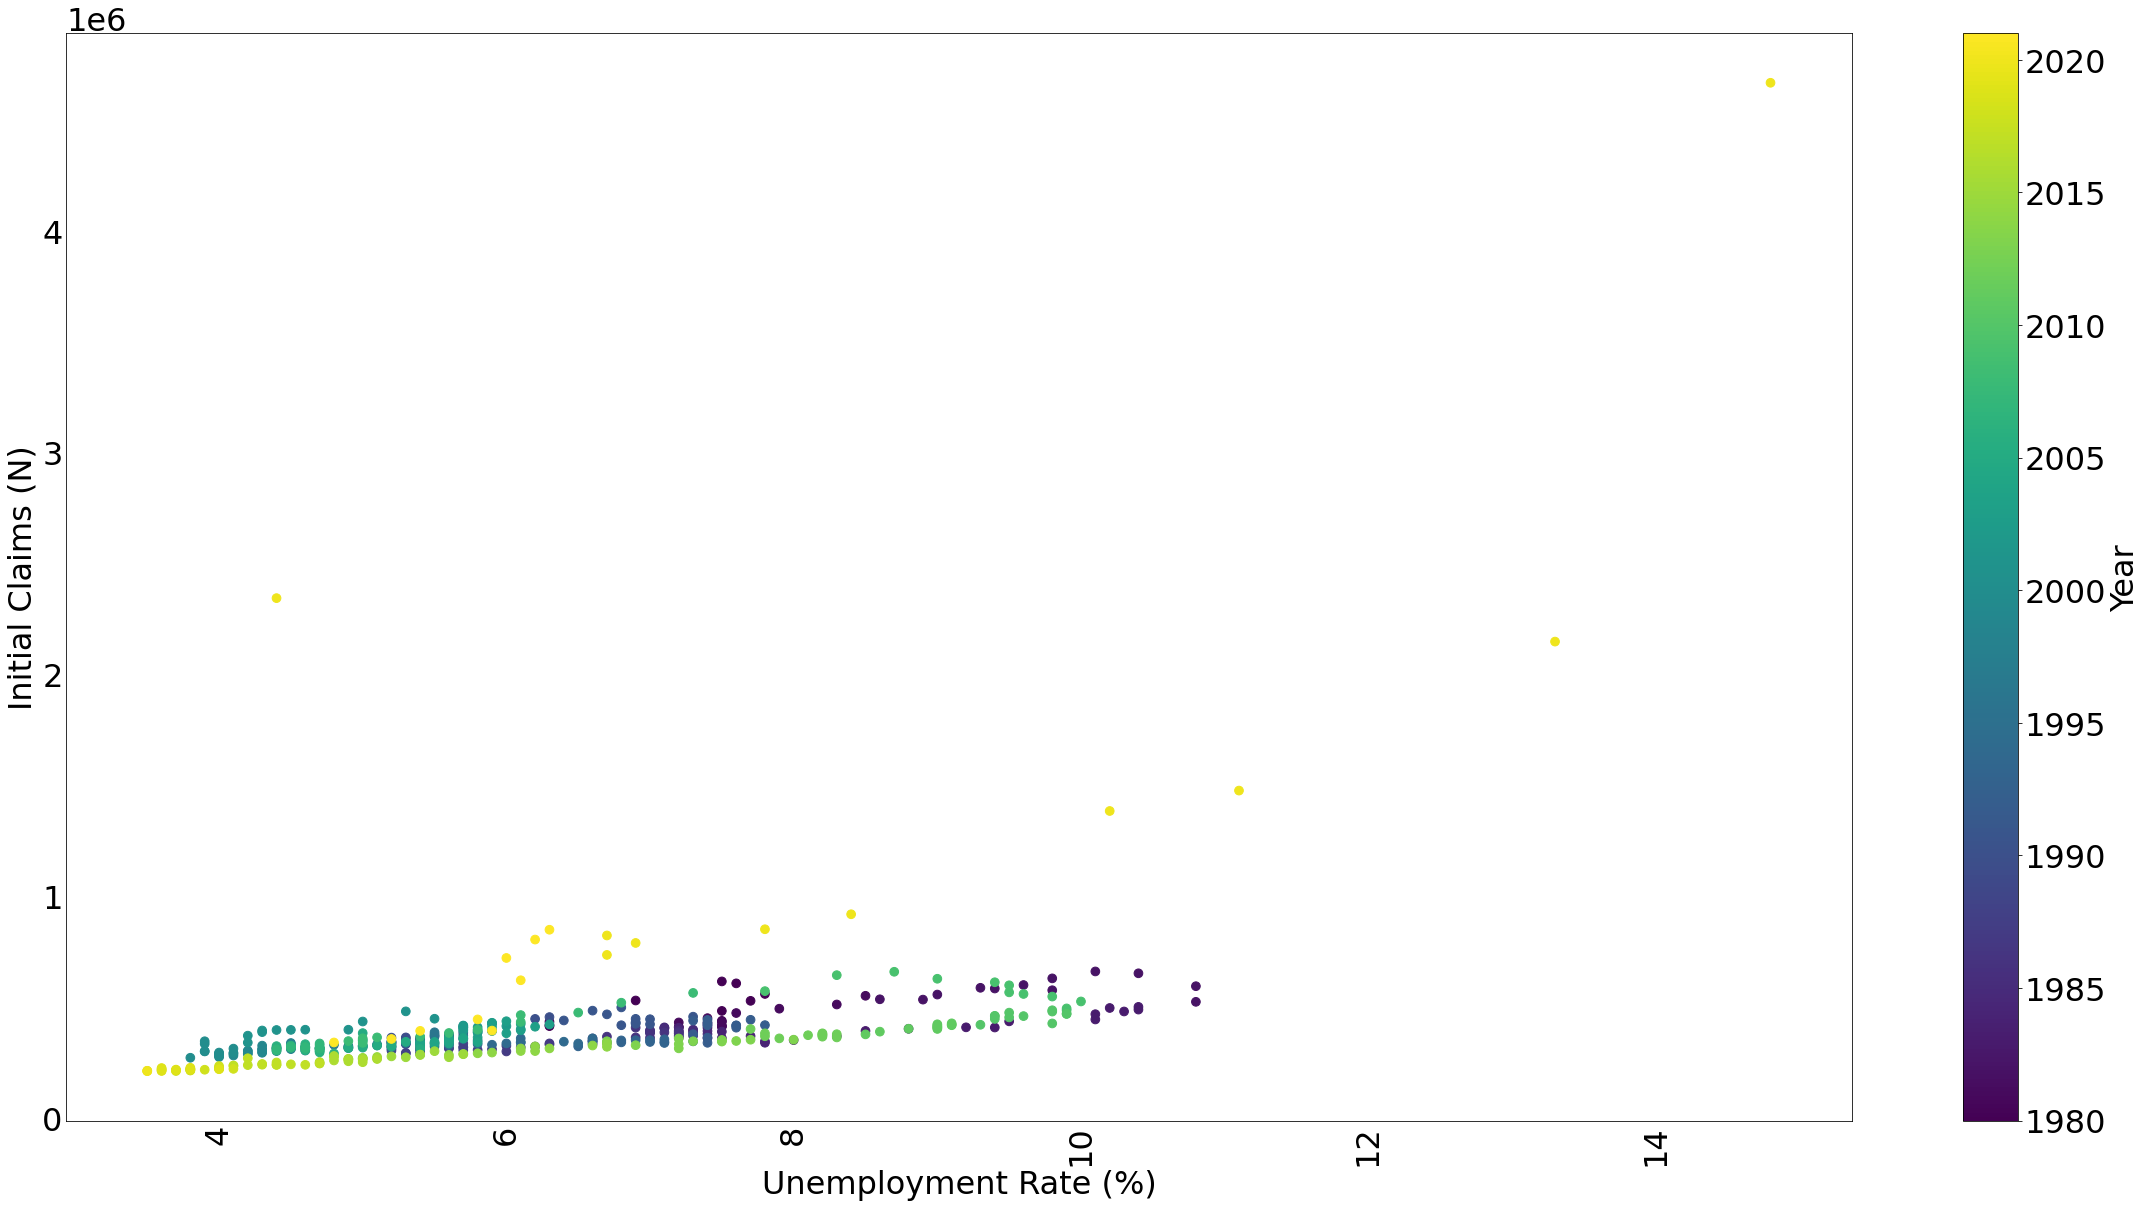

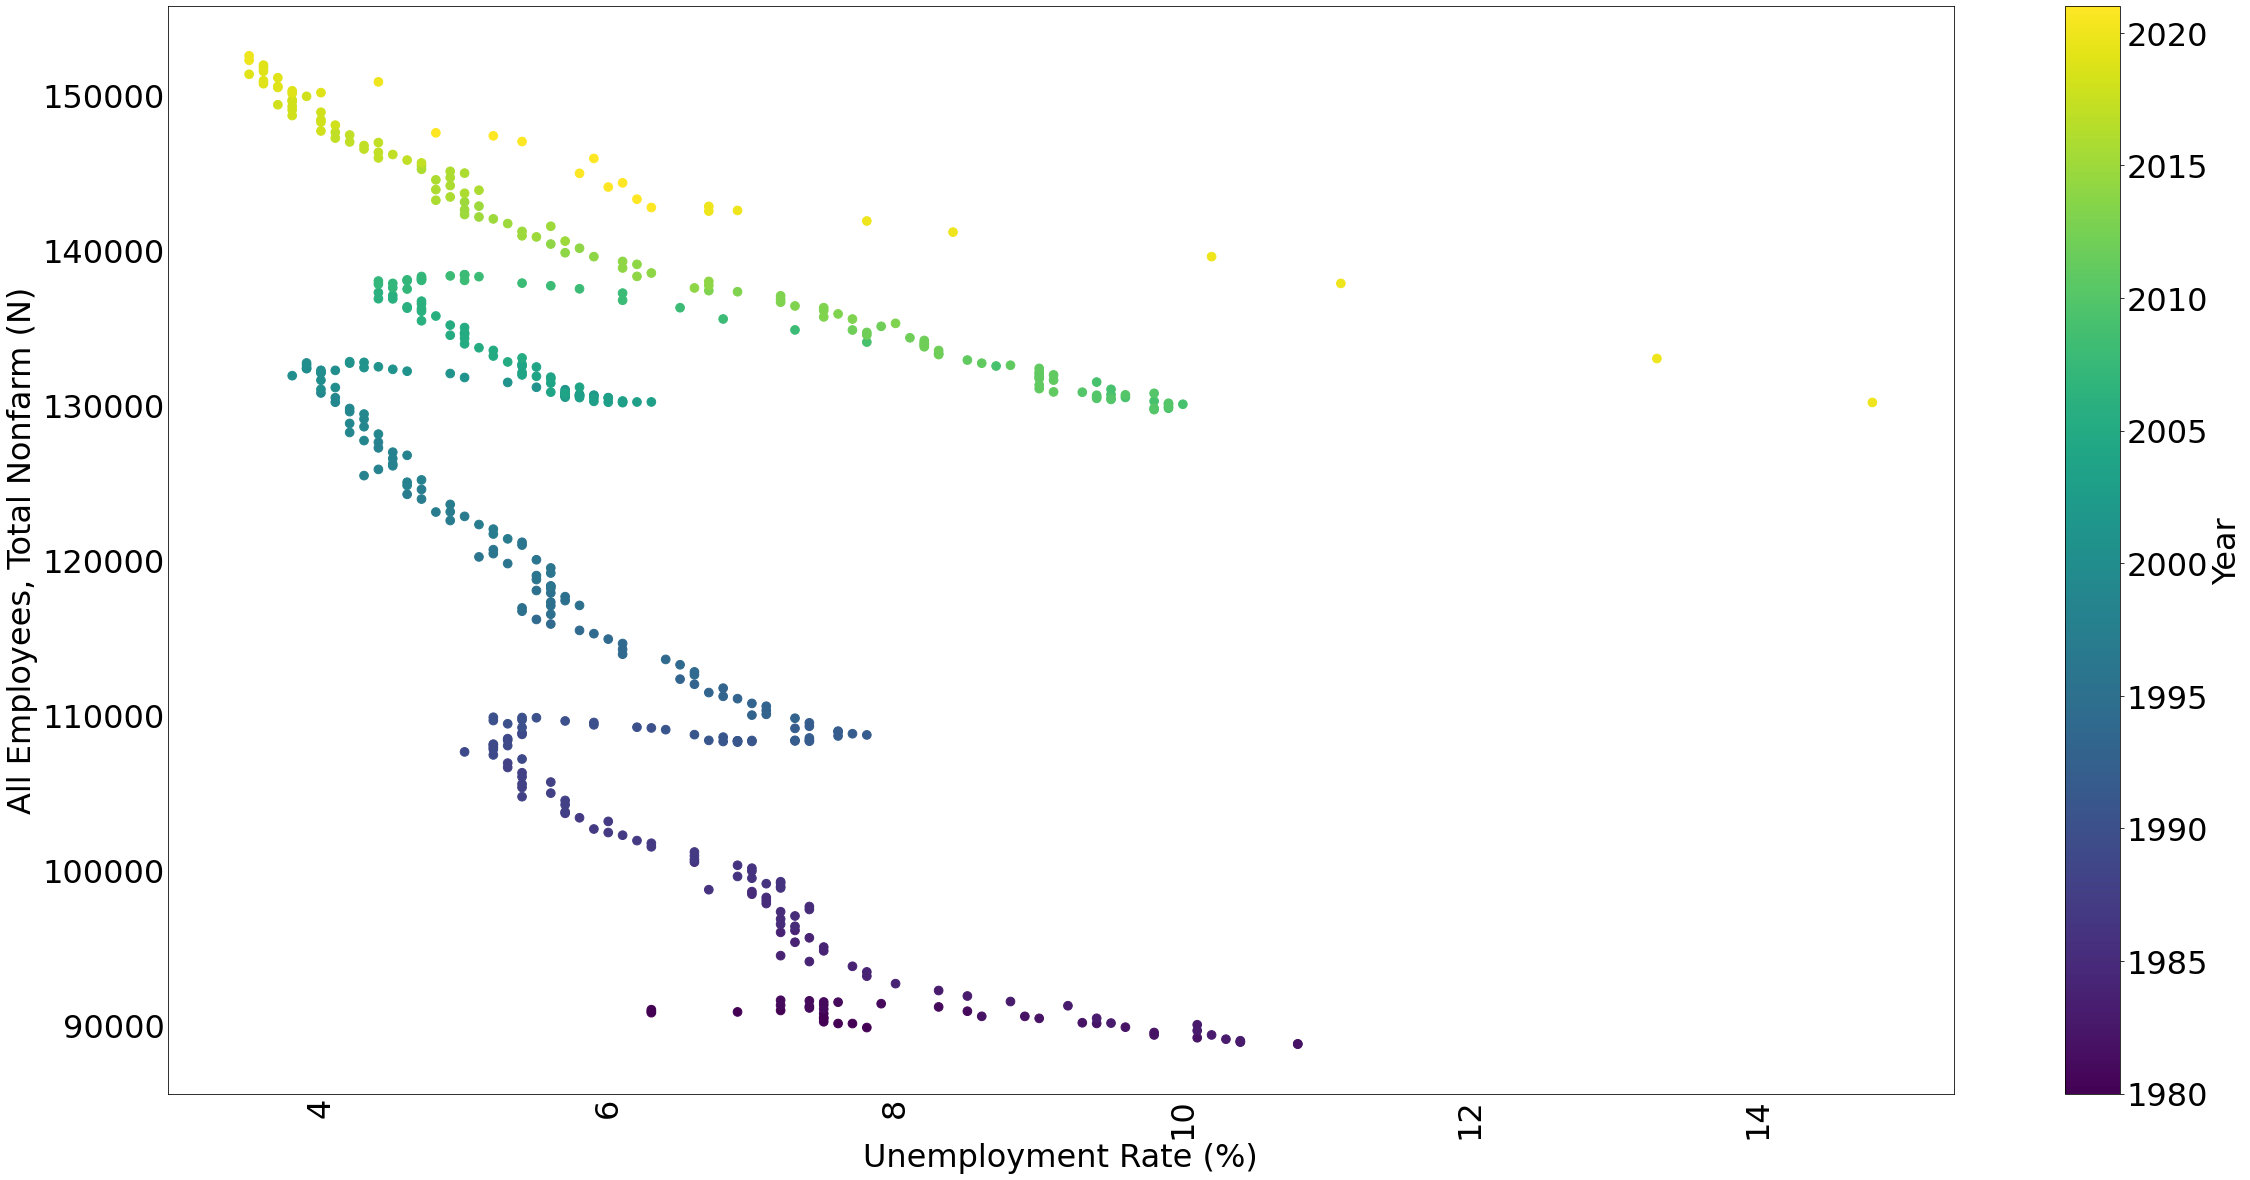

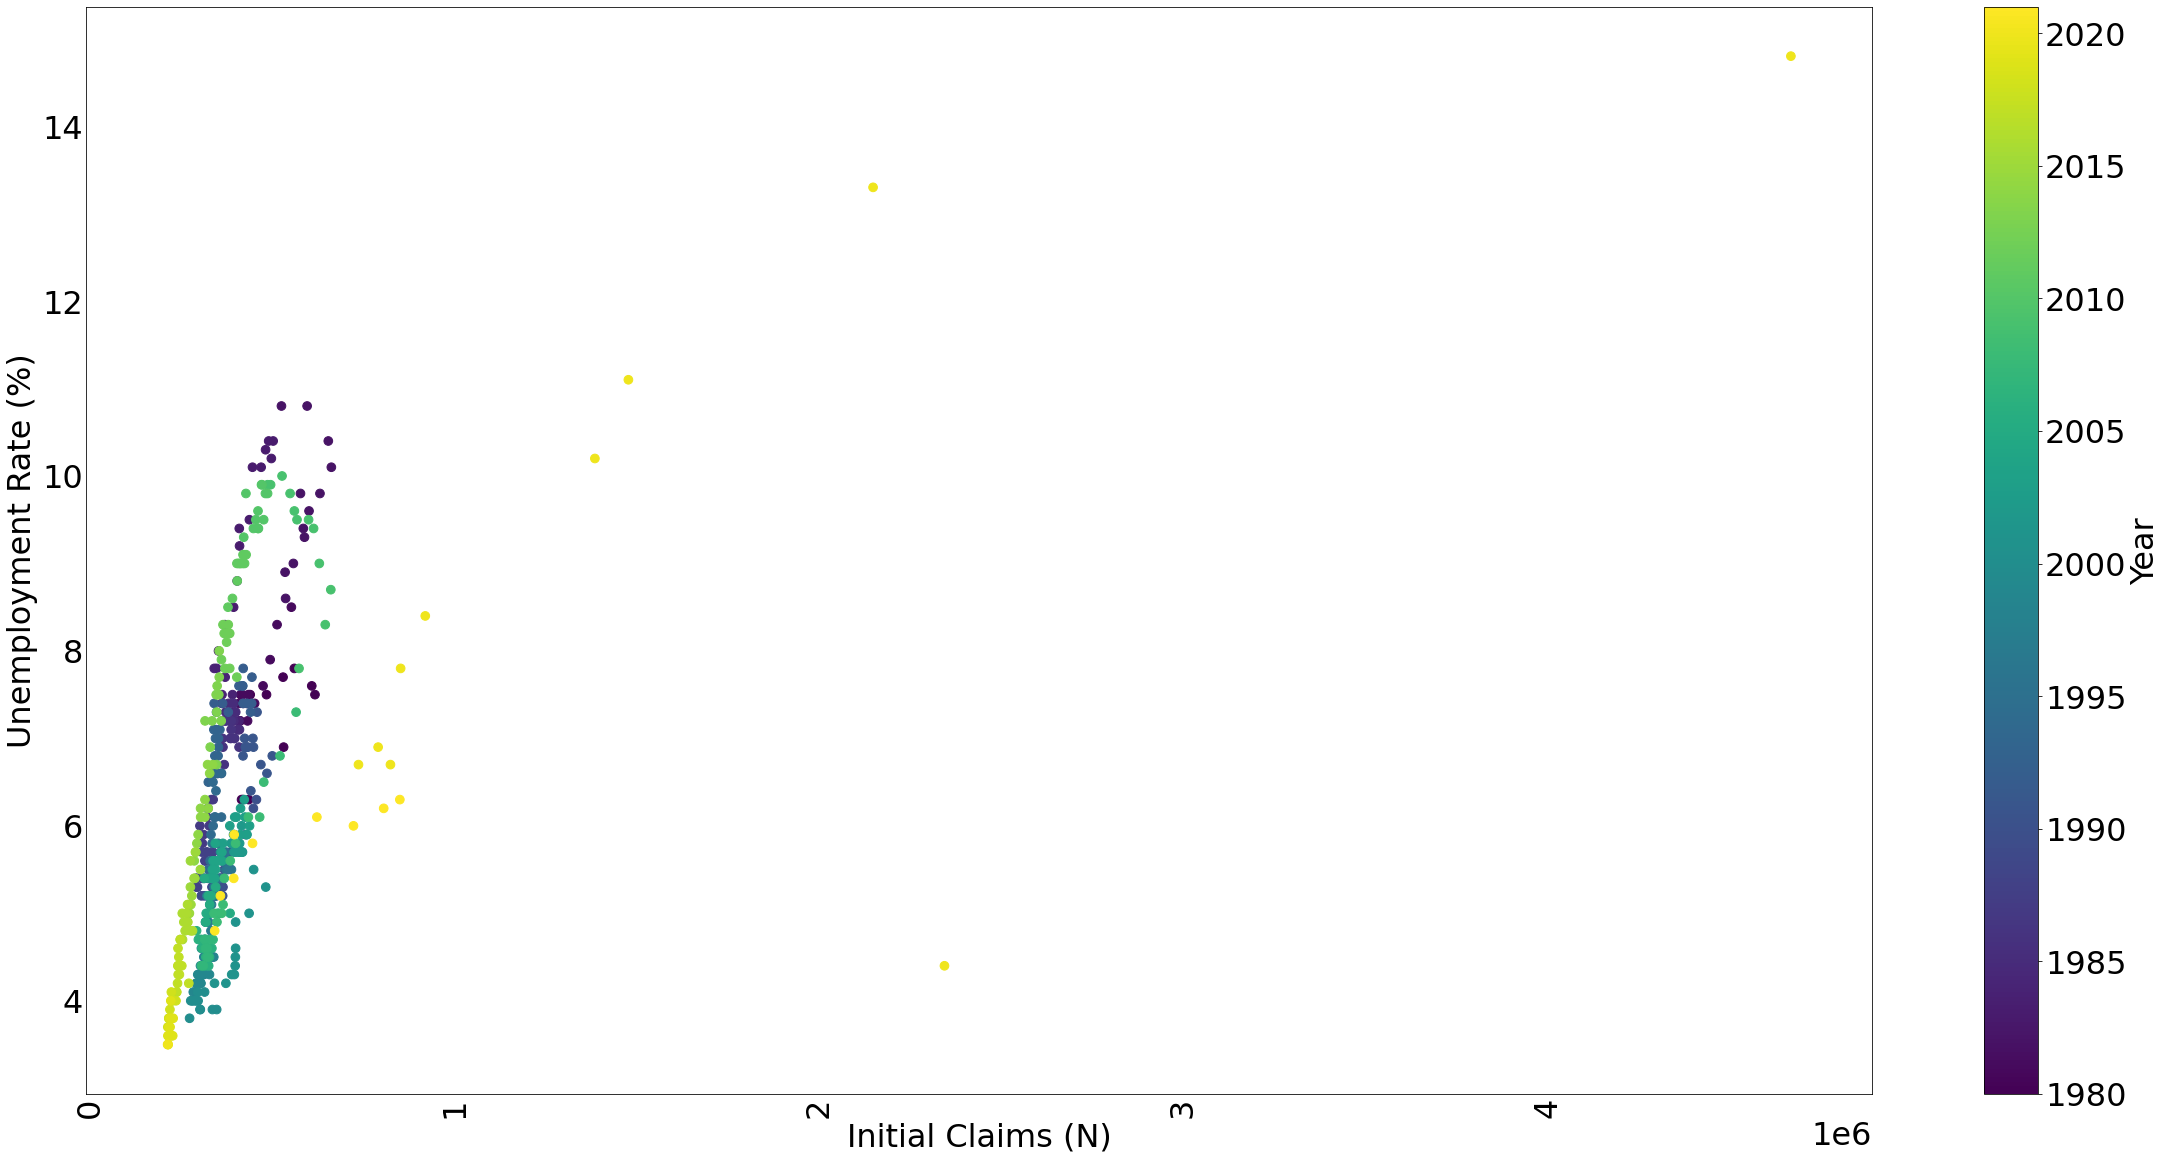

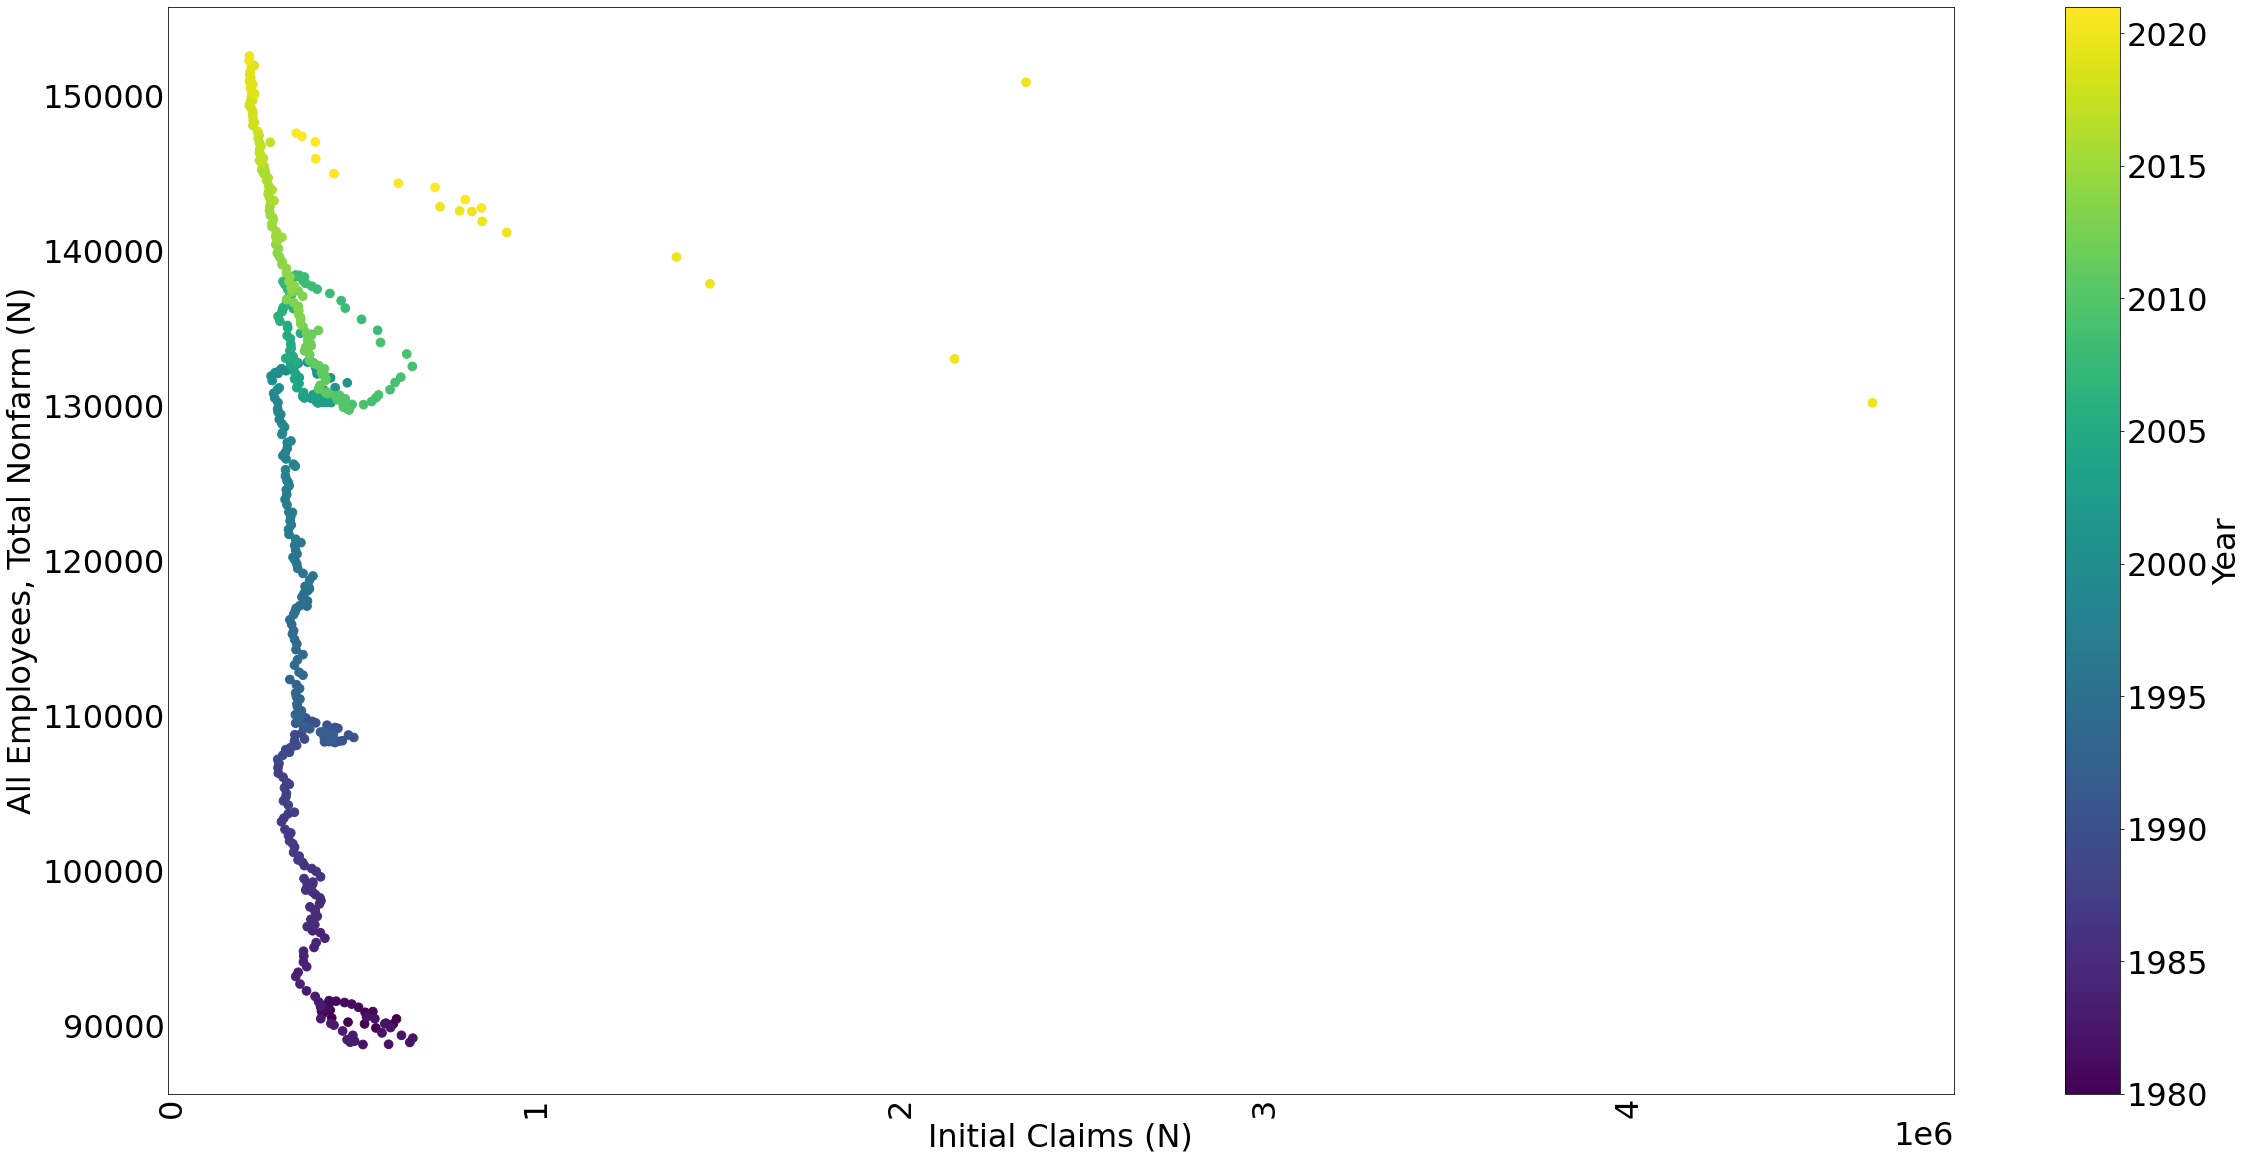

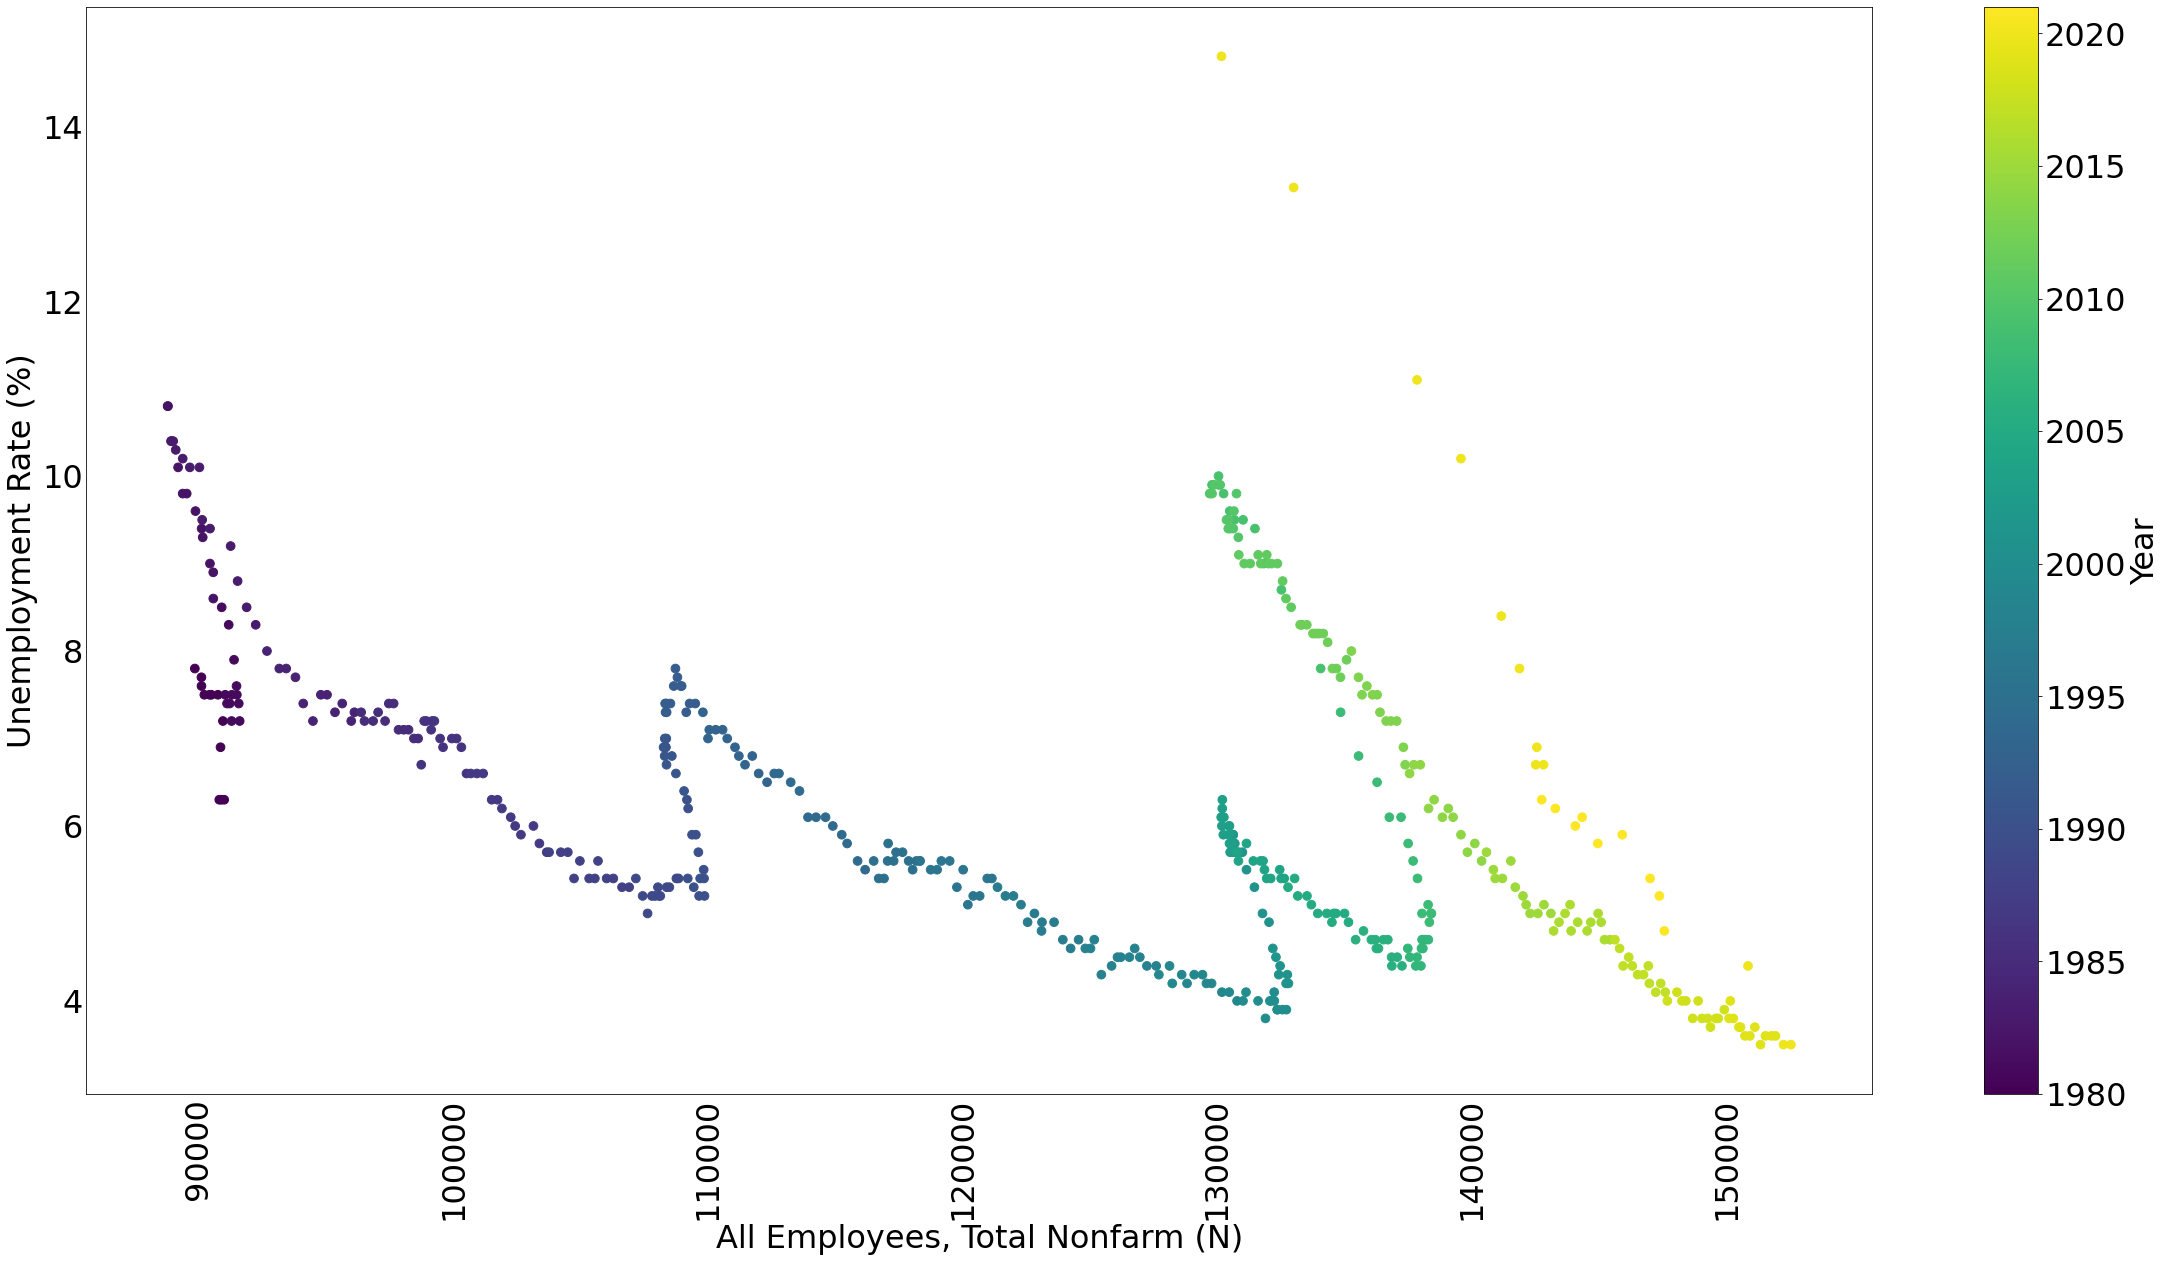

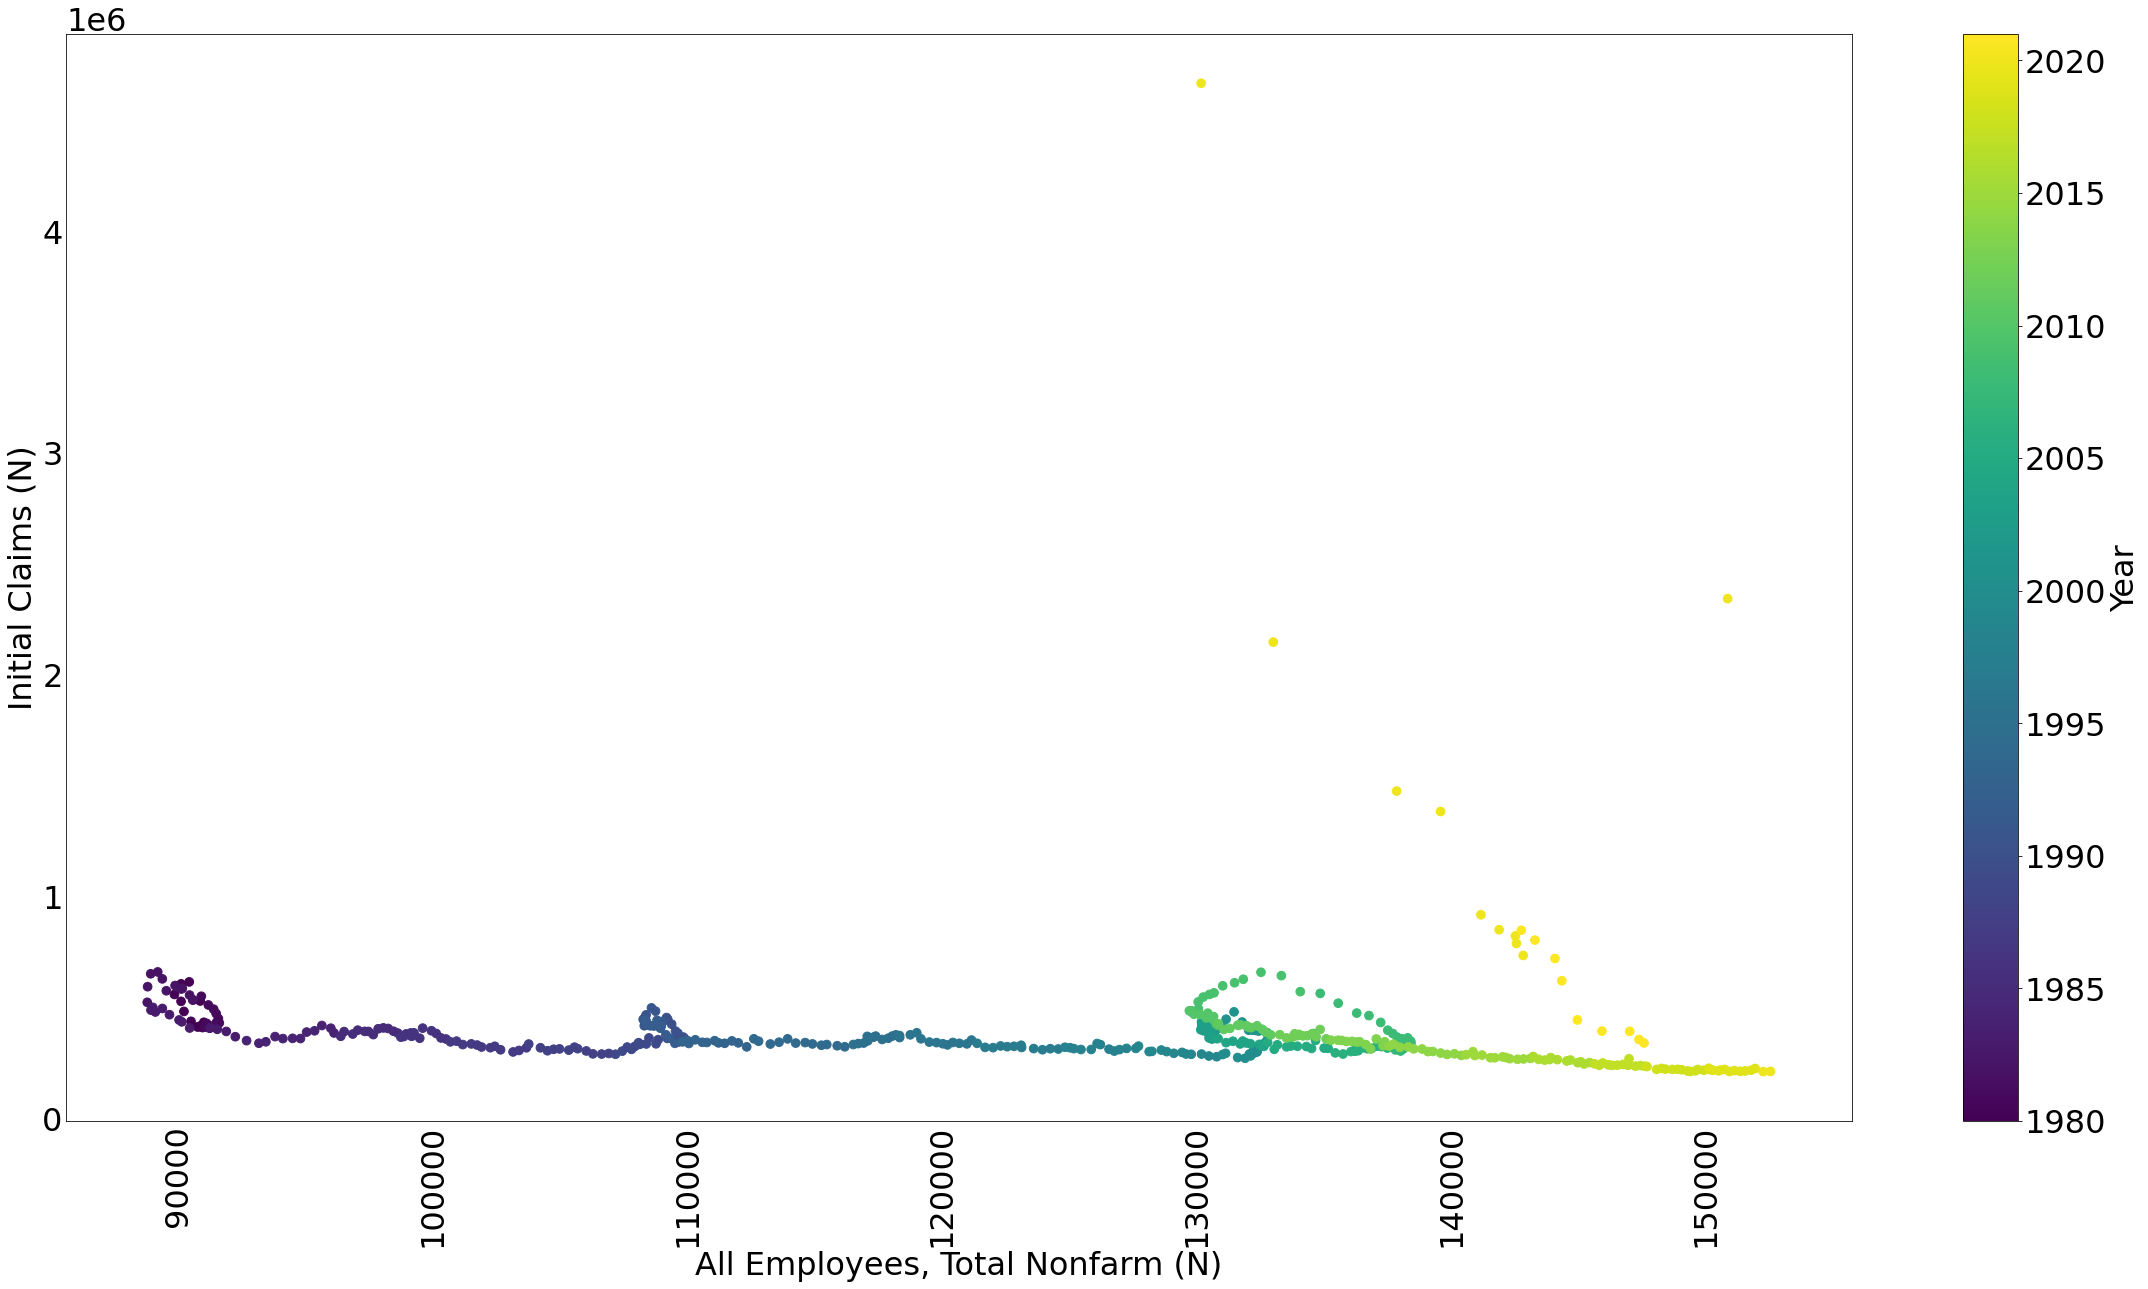

In [7]:
# Creating a scatter graph

plt.rcParams.update({"font.size":32})
plot_ts_scatter(data)

In [12]:
# Creating a correlation Matrix


import pandas as pd
from datlib.plots import * 
from datlib.FRED import *
import seaborn as sn
import matplotlib.pyplot as plt

data_Matrix = {"Nominal GDP": ["GDP"],
        "Real GDP": ["GNP"],
        "Consumer Price Index": ["CPIAUCSL"]}

start = datetime.datetime(1980, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
data = gather_data(data_codes = data_codes, start = start, end = end, freq = "M")

start = datetime.datetime(1980, 1, 1)
end = datetime.datetime.today()
data = gather_data(data_codes = data_codes, 
                   start = start,
                  end = end,
                  freq = "M")

df = pd.DataFrame(data_Matrix,columns=['Nominal GDP','Real GDP','Consumer Price Index'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

C:\Users\HP\Desktop\Jupyter_practice\datlib\plots.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


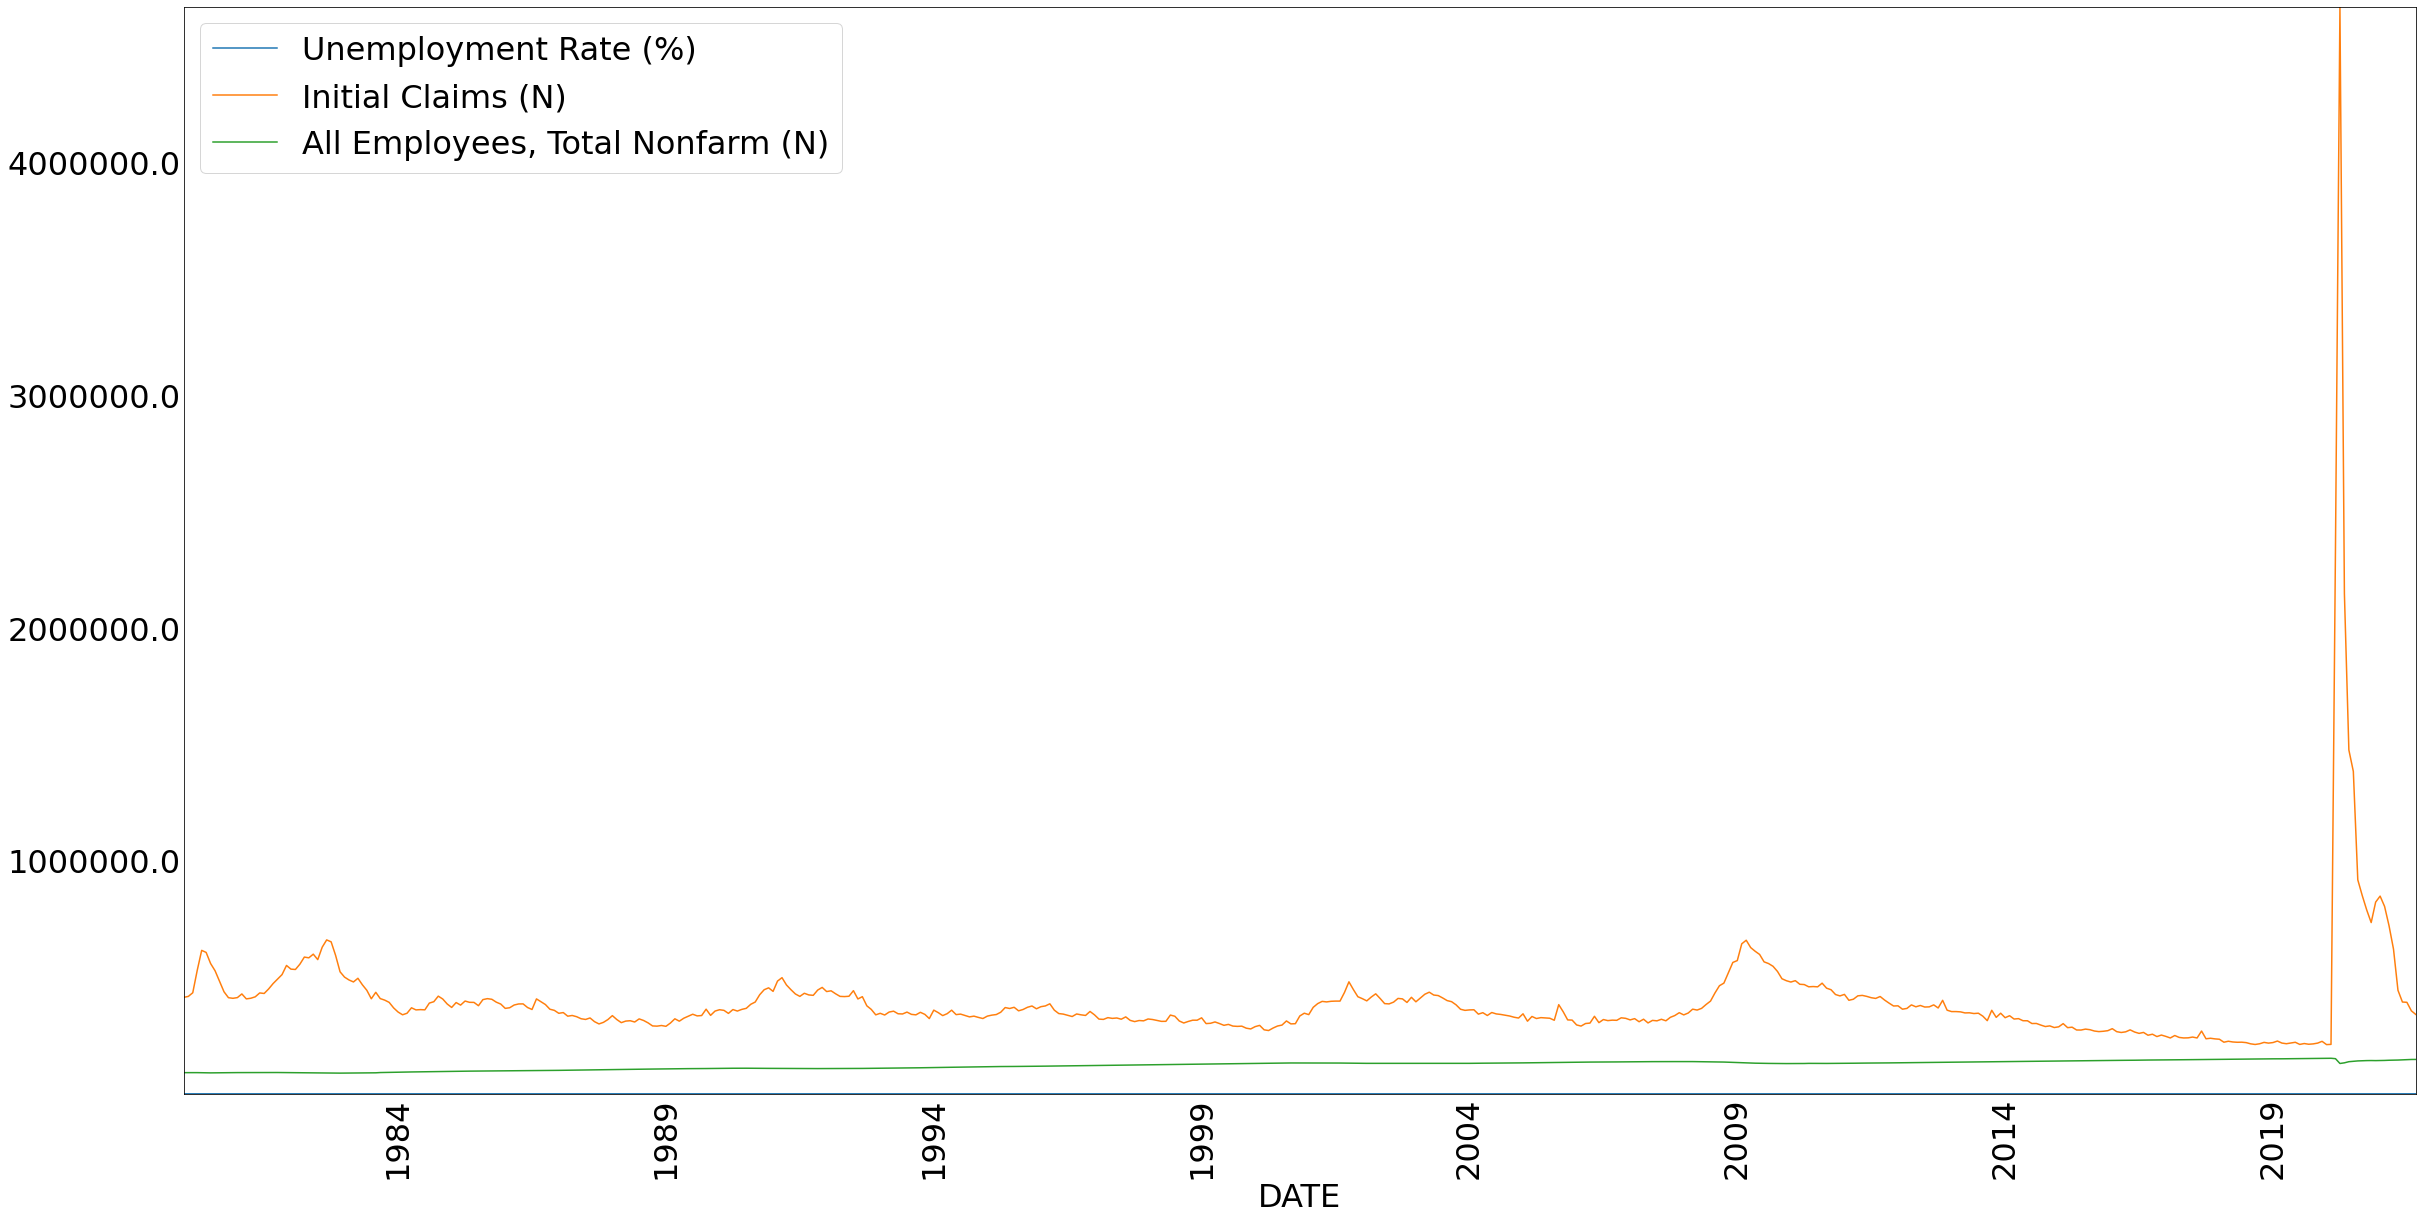

In [10]:
plt.rcParams.update({'font.size': 32})
plt.rcParams['axes.ymargin'] = 0

plot_lines(df = data, linewidth = 1.5, figsize = (40, 20), pp = None)

In [11]:
plt.rcParams.update({'font.size': 32})
plt.rcParams['axes.ymargin'] = 0

plot_lines(df = data, linewidth = 1.5, figsize = (40, 20), pp = None, show_inversion = True)

TypeError: plot_lines() got an unexpected keyword argument 'show_inversion'

In [15]:
plot_lines(df = data[["Expected Inflation(%)","Inflation(%)"]].dropna(), title = None, h_line = 2,
           legend = True, linewidth = 1.5, figsize = (40, 20), pp = None)

KeyError: "None of [Index(['Expected Inflation(%)', 'Inflation(%)'], dtype='object')] are in the [columns]"

In [18]:
plot_lines(df = data[["1 M (%)", "30 Y (%)", "30 Y - 1 M"]], title = "Yields", linewidth = 1.5, figsize = (40, 20), pp = None)

KeyError: "None of [Index(['1 M (%)', '30 Y (%)', '30 Y - 1 M'], dtype='object')] are in the [columns]"

In [19]:
T_data = data.T
T_data.rename(columns={name : str(name)[:10] for name in T_data.keys()}, inplace = True)
keys = list(T_data.keys())
T_data_trunc = T_data[keys[-181::60]]
max_y = T_data.max().max()
#for key, val in T_data_trunc.items():
plot_lines(df = T_data_trunc, title = "Yield Curve", linewidth = 1.5, figsize = (40, 20), full_index = True, pp = None)

TypeError: plot_lines() got an unexpected keyword argument 'title'

In [20]:
from matplotlib.animation import FuncAnimation
import math         
def plot_curves(date, *kwargs):
    #ax.clear()
    ax.set_ylim(bottom = 0, top = max_y)
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals])
 
    # the FuncAnimation cycles from 0 to i frames,
    plot_df = df[date]
    alpha = 1 if date in write_dates else .1
    color = "C" + str(math.ceil(int(date[5:7])/3)) if date != write_dates[0] else "k"

    # If no secondary_y (axis), plot all variables at once

    plot_df.plot.line(linewidth = linewidth, ax = ax, alpha = alpha, color = color)
    if date in write_dates: 
        plt.text(len(plot_df.keys()) - 1, plot_df["30 Y (%)"], date[5:], color = color)
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(str(date)[:10] + "\n" + "Yield Curve (U.S. Treasuries)", fontsize = 30)
    print(date)
    
def init(*kwargs):
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    plt.xticks([i for i in range(len(data.index))], list(data.index))
    ax.tick_params(axis='x', rotation=90)
    # transform y-axis values from sci notation to integers
    ax.set_ylim(bottom = 0, top = max_y)
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals])

dates = list(T_data.keys())[-166:]
write_dates = dates[-1:0:-20]
df = T_data[dates].drop("30 Y - 1 M", axis = 0).drop("Expected Inflation (T10YIE)", axis = 0)
max_y = df.max().max()
fig, ax = plt.subplots(figsize=(40,20))   
plt.rcParams.update({"font.size": 30})
linewidth = 5
# the functions will unpack the tuple. The same names variable names
# are used in the function
kwargs = (df, fig, ax, max_y, linewidth, write_dates)
frames = dates
anim = FuncAnimation(fig, plot_curves, frames = frames, 
                     blit = False, init_func = init, interval=100, 
                     fargs =kwargs)
# Use the next line to save the video as an MP4.
anim.save("2020CrisisYieldCurve.mp4", writer = "ffmpeg")
plt.close()

KeyError: "['30 Y - 1 M'] not found in axis"

In [21]:
dates = list(T_data.keys())[:200]
write_dates = dates[-1:0:-20]
df = T_data[dates].drop("30 Y - 1 M", axis = 0).drop("Expected Inflation (T10YIE)", axis = 0)
max_y = df.max().max()
fig, ax = plt.subplots(figsize=(40,20))   
plt.rcParams.update({"font.size": 30})
linewidth = 5
# the functions will unpack the tuple. The same names variable names
# are used in the function
kwargs = (df, fig, ax, max_y, linewidth, write_dates)
frames = dates
anim = FuncAnimation(fig, plot_curves, frames = frames, 
                     blit = False, init_func = init, interval=100, 
                     fargs =kwargs)
# Use the next line to save the video as an MP4.
anim.save("2008CrisisYieldCurve.mp4", writer = "ffmpeg")
plt.close()

KeyError: "['30 Y - 1 M'] not found in axis"